In [1]:
import numpy as np
import scipy as sp
import pylab as pl
pl.rcParams['figure.figsize'] = 4,4

In [2]:
from gmm_base import *

In [3]:
lamb = lambda t: 2**(-t/2)
xmax = 4
cond = 2
sample_size = int(1e4)
num_clusters = 10

(-0.2, 4)

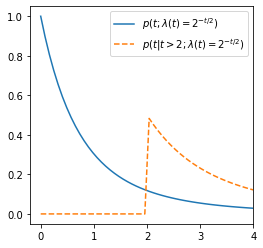

In [4]:
ex = np.linspace(0, xmax)
pl.plot(ex, lamb(ex)*np.exp([
        -sp.integrate.quad(lamb, 0, x)[0] for x in ex
    ]), label=f'$p(t;\lambda(t)=2^{{-t/2}})$')

pl.plot(ex, np.where(
    ex<cond, 0,
    lamb(ex)*np.exp([
        -sp.integrate.quad(lamb, cond, x)[0] if x>cond else np.nan
        for x in ex
    ])
), ls='--', label=f'$p(t|t>{cond};\lambda(t)=2^{{-t/2}})$')

pl.legend(loc='upper right')
pl.xlim(xmax=xmax)

### data generation

In [5]:
u = np.random.RandomState(0).rand(sample_size)
x = np.hstack([sp.optimize.fsolve(
    lambda t: np.exp(-sp.integrate.quad(lamb, 0, t)[0])-ut, 0
) for ut in u])

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


(-0.2, 4)

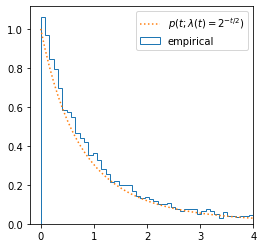

In [6]:
ex = np.linspace(0, xmax)
pl.hist(x, ex, density=True, fill=False, histtype='step',
        label='empirical');

pl.plot(ex, lamb(ex)*np.exp([
        -sp.integrate.quad(lamb, 0, x)[0] for x in ex
    ]), ':', label=f'$p(t;\lambda(t)=2^{{-t/2}})$')

pl.legend(loc='upper right')
pl.xlim(xmax=xmax)

# fit GMM

In [7]:
model = GMMModel(x[:,None], num_clusters=num_clusters)
trainer = GMMTrainer(model)

for t,epoch in elapsed(range(100)):
    trainer(x[:,None])
    if np.allclose(np.log2(epoch+1), np.round(np.log2(epoch+1))) or epoch+1==100:
        loglik = model(mx.nd.array(x[:,None]))[0].mean().asscalar()
        print(f'{epoch+1} loglik={loglik:.3f} elapsed={t:.1f}s')

1 loglik=-2.561 elapsed=0.0s
2 loglik=-2.043 elapsed=0.1s
4 loglik=-1.898 elapsed=0.1s
8 loglik=-1.795 elapsed=0.2s
16 loglik=-1.684 elapsed=0.4s
32 loglik=-1.648 elapsed=0.7s
64 loglik=-1.643 elapsed=1.4s
100 loglik=-1.641 elapsed=2.2s


In [8]:
lamb0 = infer_lambda(model, xmin=0, xmax=cond)
lamb2 = infer_lambda(model, xmin=cond, xmax=xmax)
print(f'inferred lamb(0)={lamb0:.3f}, lamb(2)={lamb2:.3f}')

inferred lamb(0)=0.956, lamb(2)=0.498


In [9]:
def mixture_pdf(ex):
    log_marg = model(mx.nd.array(ex, dtype='float32'))[0]
    return log_marg.exp().asnumpy()

(-0.2, 4)

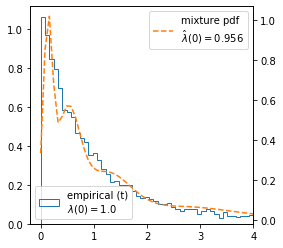

In [10]:
ex = np.linspace(0, xmax)
pl.hist(x, ex, density=True, fill=False, histtype='step',
        label=f'empirical (t)\n$\lambda(0)={lamb(0)}$')
pl.legend(loc='lower left')
pl.twinx()

pl.plot(ex, mixture_pdf(ex[:,None]),
        '--', color='C1',
        label=f'mixture pdf\n$\hat\lambda(0)={lamb0:.3f}$')
pl.legend(loc='upper right')
pl.xlim(xmax=xmax)

(-0.2, 4)

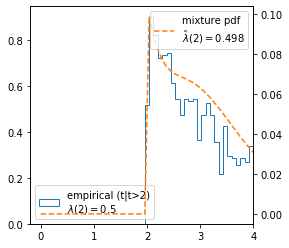

In [11]:
ex = np.linspace(0, xmax)

pl.hist(x[x>cond], ex, density=True, fill=False, histtype='step',
        label=f'empirical (t|t>{cond})\n$\lambda({cond})={lamb(cond)}$');
pl.legend(loc='lower left')
pl.twinx()

pl.plot(ex, np.where(ex<cond, 0, mixture_pdf(ex[:,None])),
        '--', color='C1',
        label=f'mixture pdf\n$\hat\lambda({cond})={lamb2:.3f}$')
pl.legend(loc='upper right')

pl.xlim(xmax=xmax)